<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/solutions/hierarchical_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hierarchical forecasting
In this exercise we will write a deterministic reconciliation algorithm. Given $n_d$ time series, $n_b$ bottom time series and $n_u$ aggregations, we want to reconcile the base forecasts produced independently.



This code can then be applied to probabilistic reconciliation through the following steps:

1. (Independently or jointly) sample from the predictive distribution ($[F_i(y_i)]_{i=1}^{n_d}$ or $F(y)$) of the base forecasters, obtaining $[y_{i, t+k}]_{i=1}^{n_d}$ set of sampled forecasts
2. reconcile the $k_{th}$ sample separately
3. repeat 1-2 for $K$ times, and empirically estimate the reconciled distribution 

In [2]:
%%capture
!pip install wget
import pandas as pd
import wget
import numpy as np
data = pd.read_pickle(wget.download("https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"));

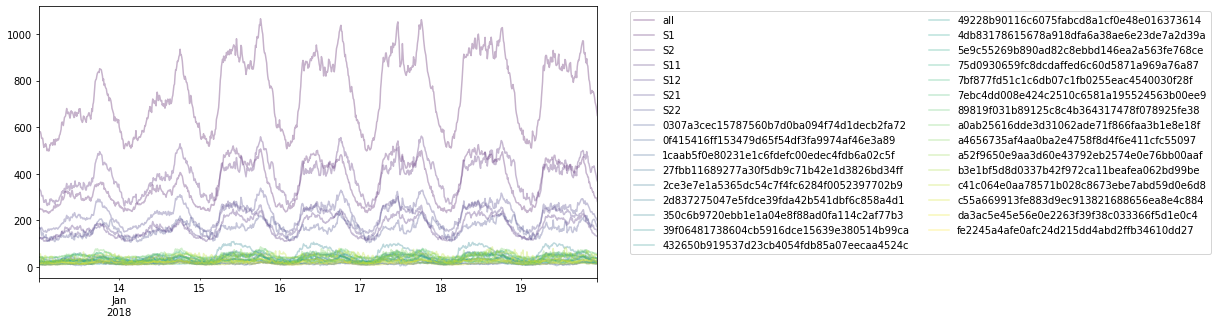

In [5]:
import matplotlib.pyplot as plt
base_series = [n for n in data.columns if n not in ["ghi_backwards", "temperature"]]
data_bs = data[base_series]
aggregated_cols = ['all','S1','S2', 'S11', 'S12', 'S21', 'S22']
data_bs = pd.concat([data_bs[aggregated_cols], data_bs[[c for c in data_bs.columns if c not in aggregated_cols]]], axis=1)
data_bs.iloc[:1000,:].plot(alpha=0.3, cmap=plt.get_cmap('viridis'), figsize=(10, 5));
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2) 

## ❓Produce the set of base forecasters
For each one of the $n_d$ time series, produce independent point forecasts and collect them in the y_hat pd.DataFrame

In [ ]:

y_hat = None 

## ❓ Obtain reconciled point forecasts
Complete the following function, in which the projection matrix is retrieved, for the `minT` method when the precision matrix $\Sigma^{-1}$ is estimated as in the dummy method or as the inverse of the base forecasts error covariance matrix.   

In [ ]:
from sklearn.covariance import ShrunkCovariance

def estimate_covariance(x, method):
    cov = ShrunkCovariance().fit(x)
    return cov.covariance_, cov.precision_
    

def get_projection_matrix(y, y_hat, bottom_series, aggregated_series, s_matrix, method='dummy'):
  errs = y - y_hat

  n_b = len(bottom_series)
  n_u = len(aggregated_series)
  
  # get forecast errors for the bottom and upper time series
  err_b = errs.loc[:, bottom_series]
  err_u = errs.loc[:, aggregated_series]

  if method == 'dummy':
    precision = np.eye(n_b + n_u)
    p_matrix = np.linalg.inv(s_matrix.T @ precision @ s_matrix) @ (s_matrix.T @ precision)

  elif method == 'minT':
    cov, precision = estimate_covariance(errs.values)
    p_matrix = np.linalg.inv(s_matrix.T @ precision @ s_matrix) @ (s_matrix.T @ precision)
  
  return p_matrix


def reconcile(y_hat, s_matrix, p_matrix, ordered_cols):
  return s_matrix @ p_matrix @ y_hat[ordered_cols].T



## ❓ Retrieve reconciled probabilistic forecasts
For just one step, retrieve the reconcile probabilistic forecasts starting from probabilistic forecasts for the bottom time series. For retrieving the latter, you can either chose a theoretic method or bootstrap on a training set.

Retrieve the reconciled forecasts for both these settings:
1. Uncorrelated $y_i$ assumption. In this case:
  1. (Independently or jointly) sample from the predictive distribution ($[F_i(y_i)]_{i=1}^{n_d}$ or $F(y)$) of the base forecasters, obtaining $[y_{i, t+k}]_{i=1}^{n_d}$ set of sampled forecasts
  2. Reconcile the $k_{th}$ sample separately
  3. Repeat 1-2 for $K$ times, and empirically estimate the reconciled distribution 
2. Bootstrap from the joint error PDF
 1. Retrieve the reconciled point forecasts for all the training set 
 2. Produce the new forecast and reconcile it. 
 3. Produce the reconciled PDF adding random samples from the error sets
